# KE5006 - Enhancer Classification

# Modelling 2

## Summary of Findings
* 2x16 GRU
  * dropouts (all layers .2/.2)
    * overfits with a maximum validation accuracy of 74.29% at 4370th epoch
  * dropouts (all layers .15/.15)
    * overfits with a maximum validation accuracy of 74.18% at 2974th epoch (in progress)
  * dropouts (all layers .1/.1)
    * overfits with a maximum validation accuracy of 75.51% at 1910th epoch

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
import platform
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("# of CPU: {0}".format(psutil.cpu_count()))
 print("CPU type: {0}".format(platform.uname()))
 print("GPU Type: {0}".format(gpu.name))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.5 GB  | Proc size: 732.8 MB
# of CPU: 2
CPU type: uname_result(system='Linux', node='fb517fd3cdea', release='4.14.79+', version='#1 SMP Wed Dec 19 21:19:13 PST 2018', machine='x86_64', processor='x86_64')
GPU Type: Tesla K80
GPU RAM Free: 11320MB | Used: 121MB | Util   1% | Total 11441MB


In [0]:
# from google.colab import files
# files.upload()

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!ls -l /content/gdrive/My\ Drive/data-enhancer

total 2178
-rw------- 1 root root 333744 Jan 29 15:06 enhancer.csv
-rw------- 1 root root 338184 Jan 29 15:06 enhancer.txt
-rw------- 1 root root  94789 Jan 29 15:06 independent.csv
-rw------- 1 root root 116293 Jan 29 15:06 independent.txt
-rw------- 1 root root 333796 Jan 29 15:06 non_enhancer.csv
-rw------- 1 root root 338234 Jan 29 15:06 non_enhancer.txt
-rw------- 1 root root 166835 Jan 29 15:06 strong.csv
-rw------- 1 root root 169049 Jan 29 15:06 strong.txt
-rw------- 1 root root 166921 Jan 29 15:06 weak.csv
-rw------- 1 root root 169135 Jan 29 15:06 weak.txt


## Load libraries

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import pytz
import pickle

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer, recall_score, roc_auc_score, roc_curve 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate


from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Load data

In [7]:
enhancer_df = pd.read_csv('/content/gdrive/My Drive/data-enhancer/enhancer.csv')
enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [0]:
enhancer_df['enhancer'] = np.ones((len(enhancer_df),))

In [9]:
enhancer_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


In [10]:
non_enhancer_df = pd.read_csv('/content/gdrive/My Drive/data-enhancer/non_enhancer.csv')
non_enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [0]:
non_enhancer_df['enhancer'] = np.zeros((len(non_enhancer_df),))

In [12]:
non_enhancer_df.head()

,id,sequence,enhancer
0,CHRX_2970600_2970800,CAGTCACATCTGTAATCACAATACGTTGGGAGGCTGAGGCAGGAGG...,0.0
1,CHRX_6179400_6179600,ACTTTGAAGAAGTCAGTCATCAAGATGAGAGACCCAACTGTCAAGC...,0.0
2,CHRX_11003079_11003279,TCGGCCTCCCAAAGTGCTGGGATTATAGGCATGAGCTACTGCACCC...,0.0
3,CHRX_22042679_22042879,TGGGAGCTGTATCAATCATGTTTTTTATTTTCTATATTTTATGATG...,0.0
4,CHRX_23280479_23280679,TACAGCAAATAGCCTTGGCAGATACAGTGTTTCCCTCCAGAGCAAA...,0.0


## Combine the data frames to form a single dataset

In [13]:
all_data_df = pd.concat([enhancer_df, non_enhancer_df])
all_data_df.reset_index(drop=True, inplace=True)
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 3 columns):
id          2968 non-null object
sequence    2968 non-null object
enhancer    2968 non-null float64
dtypes: float64(1), object(2)
memory usage: 69.6+ KB


In [14]:
all_data_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


All the sequences are of length 200 characters.

In [15]:
all_data_df['sequence'].map(lambda x: len(x)).value_counts()

200    2968
Name: sequence, dtype: int64

## Prepare the sequence data for modelling

Initialise the keras tokenizer

In [0]:
tokenizer =  Tokenizer(num_words=4, lower=False, char_level=True)

In [0]:
tokenizer.fit_on_texts(all_data_df['sequence'][0])

In [18]:
tokenizer.word_index

{'A': 3, 'C': 4, 'G': 1, 'T': 2}

In [19]:
tokenizer.index_word

{1: 'G', 2: 'T', 3: 'A', 4: 'C'}

Test the tokenizer on the first sequence

In [20]:
all_data_df['sequence'][0][:10]

'CACAATGTAG'

In [21]:
tokenizer.texts_to_matrix(all_data_df['sequence'][0], mode='binary')[:10]

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

Create a transformation pipleline to prepare the training dataset for RNN.

In [0]:
# This class selects the desired attributes and drops the rest.
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

In [0]:
# This class converts a nucleotide base (A, C, G, T) to one-hot-encoding.
class one_hot_encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.tokenizer = Tokenizer(num_words=4, lower=False, char_level=True)

    def fit(self, X, y=None):
        # Note that X is a data frame.
        # Fit the tokenizer on the 1st sequence in the dataset.
        self.tokenizer.fit_on_texts(X.iloc[0, 0])
        self.len_sequence = len(X.iloc[0, 0])
        return self

    def transform(self, X):
        # Note that X is a data frame.
        one_hot_X = X.iloc[:, 0].map(lambda x: tokenizer.texts_to_matrix(x, mode='binary')).values
        one_hot_X = np.concatenate(one_hot_X)
        one_hot_X = np.reshape(one_hot_X, (-1, self.len_sequence, 4))
        return one_hot_X

In [0]:
attrbs = ['sequence']
my_pipeline = Pipeline([
    ('selector', DataFrameSelector(attrbs)),
    ('one_hot_encoder', one_hot_encoder())
])

In [25]:
X = my_pipeline.fit_transform(all_data_df)
X.shape

(2968, 200, 4)

Check the 1st sequence is correctly encoded.

In [26]:
X[0, :10, :]

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [27]:
y = all_data_df['enhancer'].values
y.shape

(2968,)

In [28]:
y[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Split the dataset into train / validation sets

For the initial base model, we will use a simple train / validation split. 5-fold cross-validation will be used during model fine-tuning to obtain the final model.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=123)

In [30]:
X_train

array([[[0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]],

       [[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]],

       ...,

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0.],
        [0., 0.

In [31]:
X_train[0][:10]

array([[0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [32]:
y_train.shape

(1988,)

In [33]:
y_train[0]

1.0

## Train a base RNN model

In this training phase, the aim is to find a base model with statistical power which overfits. Interatively, this base model will be scaled up first to overfit, to be followed by regularization, to improve the validation accuracy.

In the next phase, cross-validation will be applied to obtain better estimates of validation accuracy. Grid-search can be applied to fine-tune the parameters, hyper-parameters to further improve the validation accuracy.

### 2 Layer 16 Node GRU

#### Apply dropout regularization (.2/.2) to the base model to reduce overfitting / achieve a higher accuracy

In [0]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [0]:
model = Sequential()
model.add(layers.GRU(16, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, reset_after=True, return_sequences=True, input_shape=(None, X_train.shape[-1])))
model.add(layers.GRU(16, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

In [0]:
# Temporary - to remove after training is completed
# Load previous history
with open('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout0202-histories-epch6000.pkl', 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout0202-epch6000.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 16)          1056      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________


In [0]:
t1 = pytz.timezone("utc").localize(datetime.datetime.now()).astimezone(pytz.timezone("Singapore"))
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=1500, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
t2 = pytz.timezone("utc").localize(datetime.datetime.now()).astimezone(pytz.timezone("Singapore"))
print('\nTraining Duration = %s' % (t2-t1))

Training start time = 2019-02-12 09:49:07.995842+08:00

Training Duration = 3:25:27.641705


In [0]:
# histories = []  # only for first training session
histories.append(history.history)

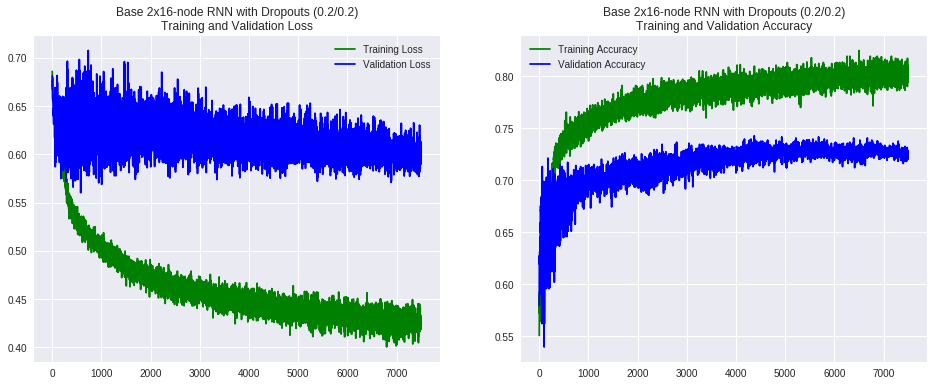

In [0]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_acc in history['acc']:
        train_acc.append(a_acc)
    for a_val_acc in history['val_acc']:
        val_acc.append(a_val_acc)

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 2x16-node RNN with Dropouts (0.2/0.2)\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 2x16-node RNN with Dropouts (0.2/0.2)\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [0]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.56 at epoch =  578
validation accuracy =  74.29% at epoch = 4370


In [0]:
with open('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout0202-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

In [0]:
model.save('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout0202.h5')

#### Apply dropout regularization (.1/.1) to the base model to reduce overfitting / achieve a higher accuracy

In [0]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [0]:
model = Sequential()
model.add(layers.GRU(16, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.1, reset_after=True, return_sequences=True, input_shape=(None, X_train.shape[-1])))
model.add(layers.GRU(16, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.1, reset_after=True))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Temporary - to remove after training is completed
# Load previous history
with open('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout0101-histories-epch1500.pkl', 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout0101-epch1500.h5')
model.summary()

In [0]:
t1 = pytz.timezone("utc").localize(datetime.datetime.now()).astimezone(pytz.timezone("Singapore"))
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=1500, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
t2 = pytz.timezone("utc").localize(datetime.datetime.now()).astimezone(pytz.timezone("Singapore"))
print('\nTraining Duration = %s' % (t2-t1))

Training start time = 2019-02-12 14:15:54.781935+08:00
Instructions for updating:
Use tf.cast instead.

Training Duration = 3:25:25.833914


In [0]:
# histories = []  # only for first training session
histories.append(history.history)

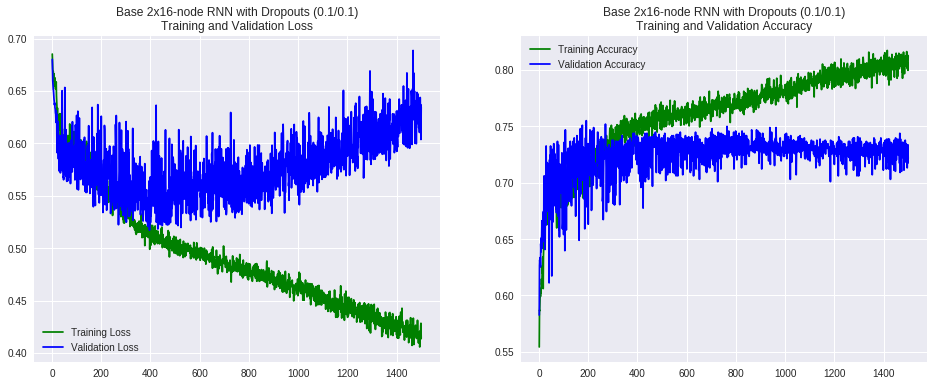

In [0]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_acc in history['acc']:
        train_acc.append(a_acc)
    for a_val_acc in history['val_acc']:
        val_acc.append(a_val_acc)

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 2x16-node RNN with Dropouts (0.1/0.1)\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 2x16-node RNN with Dropouts (0.1/0.1)\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [0]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch =  395
validation accuracy =  75.51% at epoch =  191


In [0]:
with open('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout0101-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

In [0]:
model.save('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout0101.h5')

#### Apply dropout regularization (.15/.15) to the base model to reduce overfitting / achieve a higher accuracy

In [0]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [0]:
model = Sequential()
model.add(layers.GRU(16, recurrent_activation='sigmoid', dropout=0.15, recurrent_dropout=0.15, reset_after=True, return_sequences=True, input_shape=(None, X_train.shape[-1])))
model.add(layers.GRU(16, recurrent_activation='sigmoid', dropout=0.15, recurrent_dropout=0.15, reset_after=True))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
# Temporary - to remove after training is completed
# Load previous history
with open('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout015015-histories-epch3000.pkl', 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout015015-epch3000.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 16)          1056      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________


In [42]:
t1 = pytz.timezone("utc").localize(datetime.datetime.now()).astimezone(pytz.timezone("Singapore"))
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=1000, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
t2 = pytz.timezone("utc").localize(datetime.datetime.now()).astimezone(pytz.timezone("Singapore"))
print('\nTraining Duration = %s' % (t2-t1))

Training start time = 2019-02-15 14:14:47.546181+08:00

Training Duration = 2:20:12.237159


In [0]:
# histories = []  # only for first training session
histories.append(history.history)

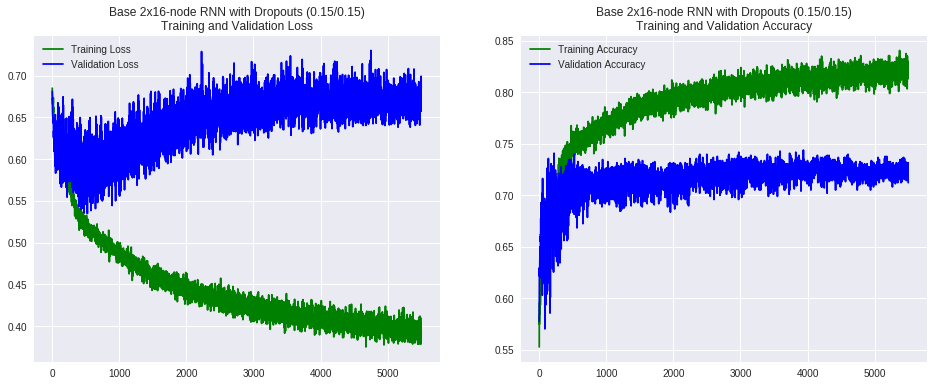

In [44]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_acc in history['acc']:
        train_acc.append(a_acc)
    for a_val_acc in history['val_acc']:
        val_acc.append(a_val_acc)

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 2x16-node RNN with Dropouts (0.15/0.15)\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 2x16-node RNN with Dropouts (0.15/0.15)\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [45]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.53 at epoch =  523
validation accuracy =  74.39% at epoch = 3937


In [0]:
with open('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout015015-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

In [0]:
model.save('/content/gdrive/My Drive/models-enhancer/base-2x16gru-dropout015015.h5')